# **Gamma Ray Spectroscopy**

In [2]:
from sort_csv import *
from process_functions import * 
import matplotlib.pyplot as plt

# Scaling Data Sets

#### Process raw data

In [3]:
bg_noise, bg_noise_uncer = input_bg()
factor, factor_uncer, df_correction  = calculate_correction_factor()
display(df_correction)

/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: overflow encountered in power
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)
/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: invalid value encountered in multiply
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)


,Unknown,Cs137,Na22,Co57,Co60,Cd109,Ba133,Eu152,Zn65,Mn54
half_life / s,86400.0,948602880.0,81993600.0,23478336.0,166194720.0,39864960.0,334281600.0,426366720.0,21075552.0,26956800.0
produce_date,2019-03-01,2022-11-01,2022-11-03,2022-11-03,2023-01-18,2022-12-16,2023-01-18,2022-09-07,2022-12-01,2019-03-01
t_exp / s,202.07,164.03,108.6,115.54,152.04,143.15,77.2,112.9,83.58,86.05
corr_factor,1.0,1.131907,0.69769,0.056887,0.79703,0.175973,2.029917,1.494032,0.049144,2.348286
uncertainty,1.0,0.001859,0.020903,0.013818,0.008403,0.015927,0.005005,0.003886,0.012178,0.066689


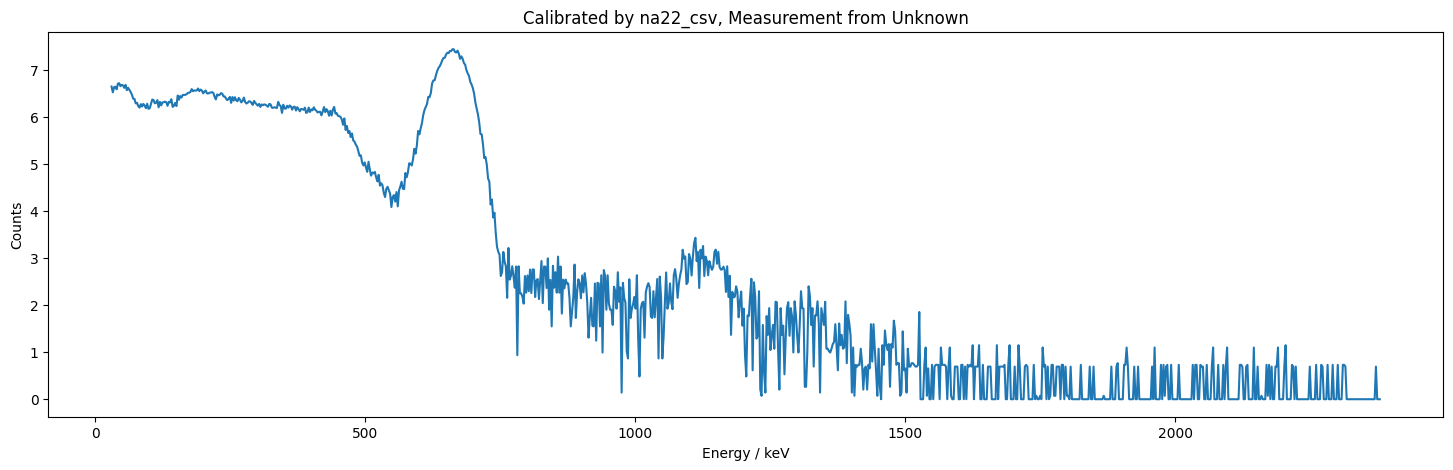

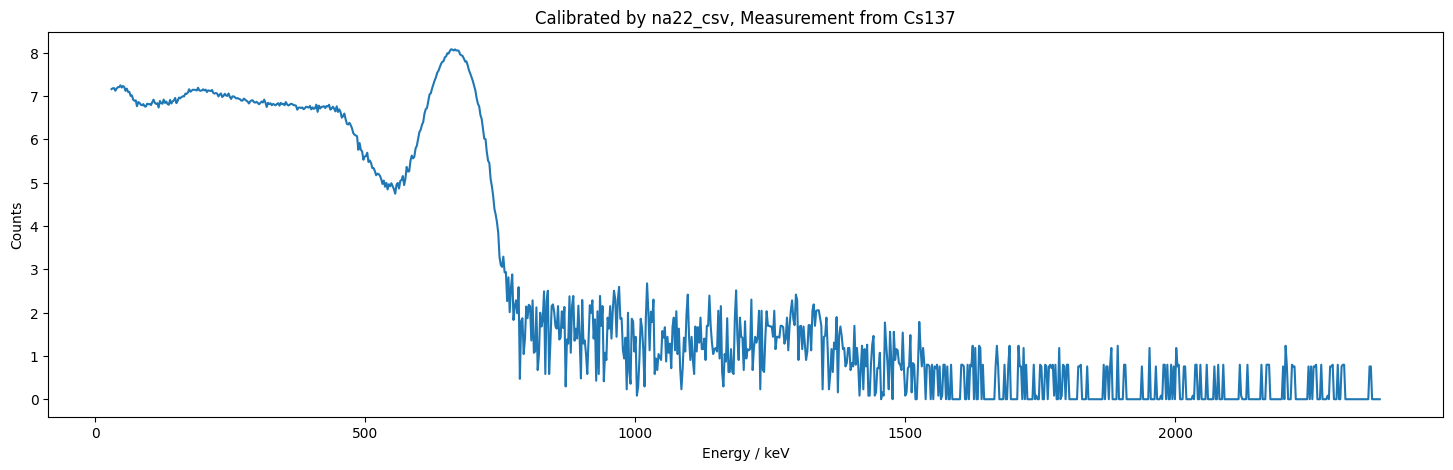

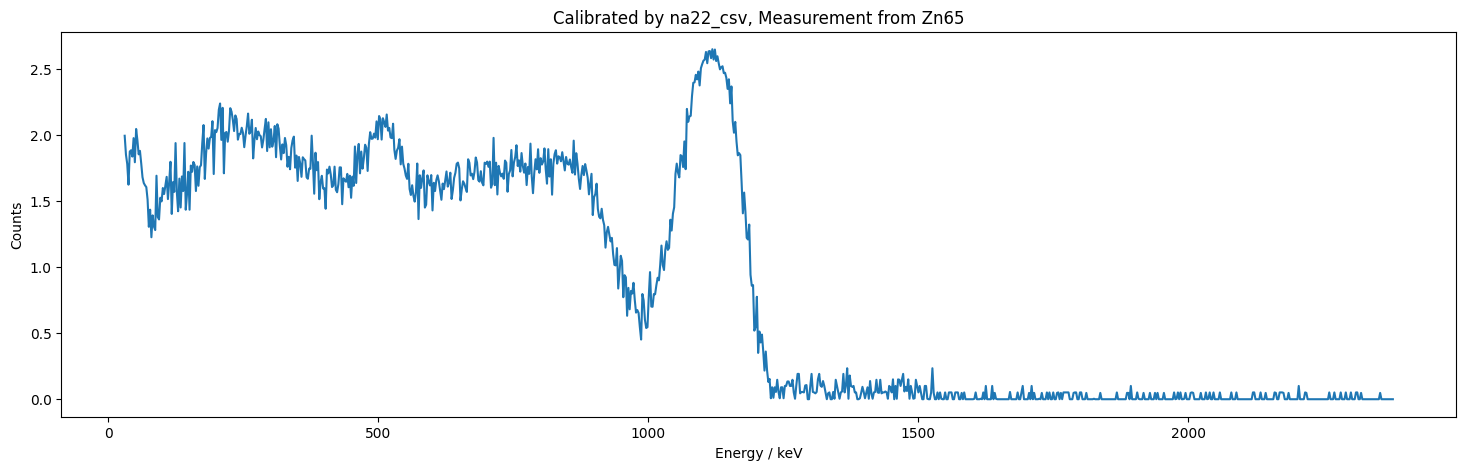

In [4]:
file_name, energy, countss, countss_uncer = read_data(bg_noise, bg_noise_uncer, 
                                                      factor, factor_uncer, 
                                                      plotting=["Unknown", "Cs137", "Zn65"])

# Spectral Analysis

#### Find the coordinate of the max counts 

Text(0.5, 0, 'Energy / keV')

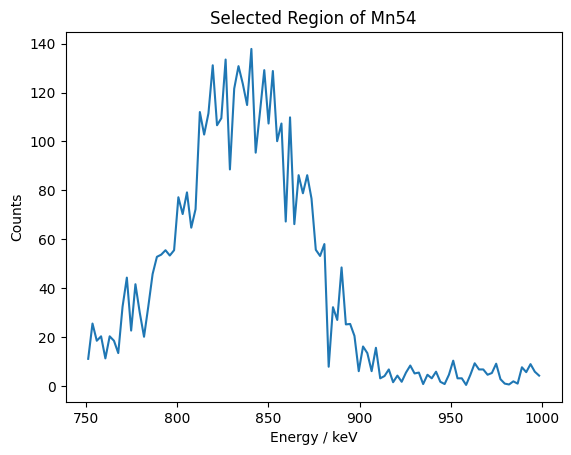

In [5]:
selected_ele = "Mn54"
y = countss[file_name.index(selected_ele)]
x = energy
x_min = 750
x_max = 1000
x_data, y_data = select_reg(x_min, x_max, x, y)
plt.plot(x_data, y_data)
plt.title("Selected Region of Mn54")
plt.ylabel("Counts")
plt.xlabel("Energy / keV")

In [6]:
x_min = 800
x_max = 900
energy_max, counts_max = find_max(x_min, x_max, x_data, y_data)
print(f"The maximum counts of {selected_ele} at range {x_min}keV to {x_max}keV\n"
      f"Located at energy {energy_max}keV, with a total counts of {counts_max}")

The maximum counts of Mn54 at range 800keV to 900keV
Located at energy 840.6913580246913keV, with a total counts of 137.8383560816767


#### Gaussian fitting to find spectral properties

N: 6097.838489978558 with uncertainty = 1476.666975515151
Center: 839.8498891535348 with uncertainty = 2.3209024589047327
Peak: 97.4409032536814


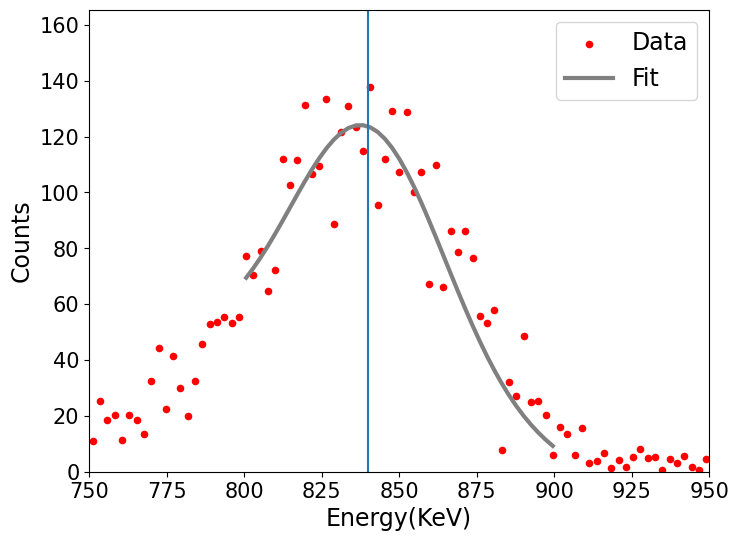

In [7]:
gaussian_fit(x_min, x_max, x_data, y_data)

## Least Square Prediction on Composition

The predictions are ['Cs137' 'Co57' 'Cd109' 'Zn65']
With proportion of [0.523 0.475 0.225 1.098]


/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/process_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  pred_uncer = pred_uncer / pred
/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/process_functions.py:125: RuntimeWarning: divide by zero encountered in log
  pred = np.log(pred)
/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/process_functions.py:126: RuntimeWarning: divide by zero encountered in log
  unknown_sample = np.log(unknown_sample)


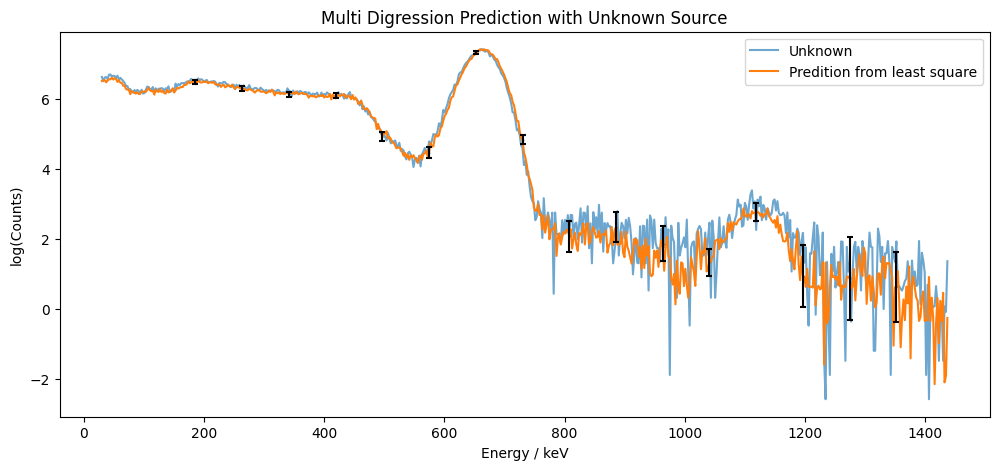

In [8]:
least_square_weights(file_name, energy, 
                     countss, countss_uncer, 
                     cond=0.05, plotting=True)